# Evaluating Local Election Campaigns

 - Robert Sincliar, Campaign Lab 

Election organisers would like to know which constituency level election campaigns were succesful. 

The initial problem was stated as finding two similar constituencies that performed very differently, so that we can retrospectively find out what was done differently. Is this possible? Will it be useful?

## Methodology

This problem can be split into three main elements. We need:

- A way to score a constitency's result
- A way to characterise a constitencies electorate
- A methodology to compare constituencies' scores, taking into account their characteristics


In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# collection of functions to read in useful datasets
import campaignlabprojects as clp

# Config
sns.set(color_codes=True)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## Score constituencies

Read in election results and calculate various scoring metrics for the labour campaing in each constituency

- `base` : Simply the % share of votes Labour recieved in a constituency
- `diff` : Difference in number of votes between an election year and the comparisson year
- `uns` : Swing to/from labour in a constituency minus the national average swing
- `mrp` : Compare the Labour vote share with the YOUGOV MRP poll carried out 4 weeks before an election, only available for GE17 and GE19



In [3]:
election_results = clp.read_in_election_results()

In [4]:
#Pick year of interest, and one to compare with (neccesary for some of the scoring methods)
year = 19 # 2019 election
compare_year = 17 # normally the previous election year

In [5]:
base = pd.DataFrame(election_results[year]['lab_pc'],
                    index=election_results[year].index)

diff = clp.score_campaigns_difference(election_results[year], 
                                      election_results[compare_year])

uns  = clp.score_campaigns_uns(election_results[year], 
                               election_results[compare_year])

mrp  = clp.score_campaigns_mrp(election_results[year])

In [6]:
# Compile all scoring metrics into one database `scores`
scores = pd.concat( [election_results[year]['Constituency'],
                     base['lab_pc'], 
                     diff['difference'],
                     uns['difference'],
                     mrp['difference'] ],
                    axis=1, verify_integrity=True, sort=True)
scores.columns = ['Constituency','base','diff','uns','mrp']
scores.sort_values('uns',ascending=False).head()

,Constituency,base,diff,uns,mrp
E14000589,Bradford West,0.762206,4292.0,0.115483,0.222206
E14000884,Portsmouth South,0.486410,4778.0,0.076008,0.066410
E14000958,Southport,0.389518,3140.0,0.063657,0.079518
E14000780,Leeds North West,0.486395,3555.0,0.045321,-0.003605
E14000887,Putney,0.451384,3655.0,0.043549,0.111384


In [7]:
#ax = sns.scatterplot(scores['base'],scores['uns'])

In [8]:
#sns.scatterplot(scores['uns'],scores['mrp'])

In [9]:
# seats that labour won by, or were within a certain percentage of winning
marginals = clp.calc_marginal_within(0.10,election_results[compare_year])

## Characterise constituencies

We use the publically available 2011 census data, broken down by constituency, to characterise the electorate. 

The features chosen are based on intuition of campaigners I spoke to and a PCA of voting intentions. This choice is currently fairly arbitrary and could be investigated further.

A basic assumption of this approach is that all voters with the same demographic information will vote the same way; this also implies no geographic or historical voting dependece.

In [10]:
census = clp.read_in_census()

In [11]:
features = ['c11PopulationDensity',
            'c11HouseOwned',
            'c11CarsNone',
            'c11EthnicityWhite',
            'c11Unemployed',
            'c11Retired',
            'c11FulltimeStudent',
            'c11Age65to74',
            'c11DeprivedNone']

In [12]:
demographic_data = census[features]
demographic_data.head()

,c11PopulationDensity,c11HouseOwned,c11CarsNone,c11EthnicityWhite,c11Unemployed,c11Retired,c11FulltimeStudent,c11Age65to74,c11DeprivedNone
ons_id,,,,,,,,,
E14000530,19.614660,65.426048,15.825351,85.533381,3.637000,10.325348,6.690939,7.028348,47.943774
E14000531,17.483482,75.594167,19.131244,93.128849,4.553607,18.657412,6.162344,11.750721,39.975178
E14000532,18.709288,74.080473,16.001903,90.433891,3.039963,14.139160,6.895702,8.780321,54.415484
E14000533,7.051190,72.468212,21.039414,98.388767,4.261173,16.989668,5.294369,10.090689,40.566761
E14000534,1.507467,75.970149,10.346654,97.748466,2.468100,18.684355,5.549608,12.340259,51.468464


### Collect census and demographic data

In [13]:
# only want rows we have election data for
demographic_data = demographic_data.loc[election_results[year].index]

# only want constituencies we have complete data for
demographic_data = demographic_data.dropna()

# Speaker seats have incomplete voting data
speaker_seats = census.index[census['constituency_name'].isin(['Chorley', 'Buckingham'])]
demographic_data = demographic_data.drop(speaker_seats)

loss = set(census.index) - set(demographic_data.index)
print('Loss =',len(loss))

Loss = 79


In [14]:
# Make some lookup containers
constits_id = demographic_data.index
constits_name = list(census.loc[constits_id]['constituency_name'])
id_to_name = {id_:name for id_,name in zip(constits_id, constits_name)}
name_to_id = {name:id_ for id_,name in zip(constits_id, constits_name)}
id_to_index = {onsid:i for i,onsid in enumerate(constits_id)}
name_to_index = {name:i for i,name in enumerate(constits_name)}

scores = scores.loc[constits_id] # only interested in these constits now

We can now see the spread of constituencies based on their demographics.

The graph below shows contituencies close to similar constituencies. Do not read too much into the axes. Points are coloured by their labour swing relative to the national labour swing.

In [15]:
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

def visualise_demographics(demographic_data, Embed=Isomap, colours=None, labels=[]):
    """
    demographic_data: Array-like, shape (n_samples, n_features)
    Embed: SKLearn Embedding class
    colours: List-like, shape (n_samples)
    lables: List of constituency names to label
    """
    Ndim = 2
    embedding = Embed(n_components=Ndim)
    X_transformed = embedding.fit_transform(demographic_data)
    x = pd.Series(X_transformed[:,0])
    y = pd.Series(X_transformed[:,1])

    plt.figure(figsize=(8,8))
    ax = sns.scatterplot(x=x, y=y, hue=colours, palette='RdYlBu_r')

    for constit in labels:
        ax.text(x[name_to_index[constit]], 
                y[name_to_index[constit]],
                constit)
        
    if Embed == PCA:
        df = pd.DataFrame(columns=range(Ndim),
                          index=demographic_data.columns)
        for axis in range(Ndim):
            for feature ,x in zip(demographic_data.columns, embedding.components_[axis]):
                df.loc[feature, axis] = x
        print(df)
    

In [16]:
#name_to_id

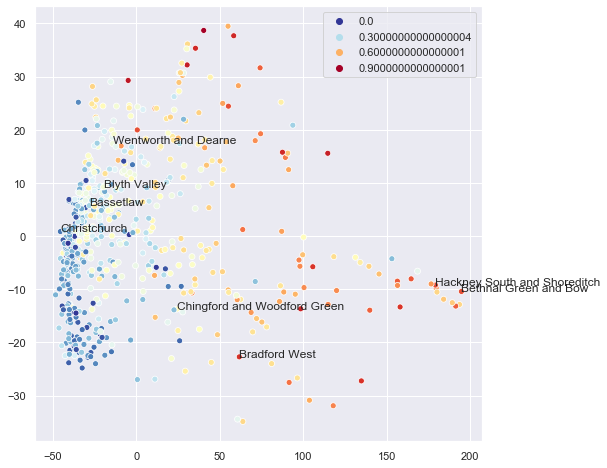

In [17]:
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

labels = ['Bethnal Green and Bow', 'Hackney South and Shoreditch',
          'Christchurch','Bradford West','Bassetlaw','Wentworth and Dearne',
          'Blyth Valley','Chingford and Woodford Green']

#colours = np.array(marginals.loc[constits_id])
#colours = np.array(scores['uns'])
colours = np.array(scores['base'])

visualise_demographics(demographic_data, Embed=Isomap, colours=colours, labels=labels)

## Concieve a metric for the success of a local campaign

All constituencies are compared with each other.

We calculate a 'distance', $r_{ij}$, between constituencies according their demographics. Similar constituencies, based on the features chosen above, will have a small distance between them.

We then calculate the relative swing between each campaign.

This relative score is divided by the distance between each constituency. Our confidence in a constituencies campaing is the sum of this value between all other constituencies.

If constituency A

 scored much better than constituency B, and they are very similar in demographics, A will recieve a positive contribution and B will recieve a negative one. 

$$\textrm{Success}_j = \sum_{i} \frac{ \Delta\textrm{swing}_{ij} }{ r_{ij} }$$

### Euclidian Distance

If we are $k$ demographic features, $f_k$, that characterise a constituency, the distance $r$ between two constituencies $i$ and $j$ is:

$$ r^{\rm{Euclidian}}_{ij} = \sum_{k}  |f_k(i) - f_k(j)| $$

In [18]:
# I also normalise each feature to give them equal weighting.
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances

def distance(X):
    X_scaled = preprocessing.scale(X)
    return pairwise_distances(X_scaled)

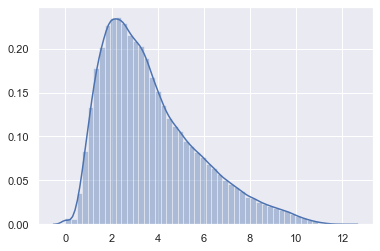

In [19]:
# Show distribution of distances between constituencies
dist_matrix = distance(demographic_data)
sns.distplot(np.ndarray.flatten(dist_matrix))

In [20]:
scores['Constituency'].iloc[np.where(dist_matrix == np.max(dist_matrix))[0]]

ons_id
E14000638           Christchurch
E14000555    Bethnal Green & Bow
Name: Constituency, dtype: object

### Non-Euclidian distances

We may want to discard constituencies that are very differnt, or give more weight constituencies that are closer together.

We could introduce a cutoff, $r_c$, beyond which we stop comparing constituencies:

$$ r^{\rm{cut}}_ij =
\begin{cases}
 r^{\rm{Euclidian}}_{ij} \; &\rm{if} \; r^{\rm{Euclidian}}_{ij} < r_c , \\
 \infty & \rm{else}
 \end{cases} $$
 
This tends to create instabilities in the model, as we will see later, a better approach would be to use the euclidian distance as an exponent:

$$ r^{\rm{exp}}_{ij} = n ^ {\; r^{\rm{Euclidian}}_{ij}} $$

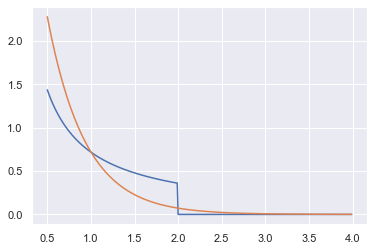

In [21]:
def norm(y):
    return y/(sum(y)*dx)

def cut(r, cutoff=1):
    r_cut = np.copy(r)
    r_cut[r>cutoff] = np.inf
    return r_cut

def exponent(r, base=math.e):
    return base**r

def contribution(r, func=lambda x:x, **kwargs):
    r = func(r, **kwargs)
    y = 1/r    
    return norm(y)

dx = 0.01
x=np.arange(0.5,4,dx)
y_cut = contribution(x, cut)

#ax = sns.lineplot(x=x, y=contribution(x))
ax = sns.lineplot(x=x, y=contribution(x, cut, cutoff=2))
ax = sns.lineplot(x=x, y=contribution(x, exponent, base=10))

In [22]:
def examples_at_dist(dist, width=0.0001):
    dist_matrix = distance(demographic_data)
    pairs = np.where( np.abs(dist_matrix - dist) < width)
    for pair in np.array(pairs).T:
        if pair[0] > pair[1]:
            print(constits_name[pair[0]], ',', constits_name[pair[1]])
        
examples_at_dist(1)

Washington and Sunderland West , Houghton and Sunderland South
Shrewsbury and Atcham , Kettering
Cynon Valley , Doncaster North
Rutland and Melton , North East Bedfordshire
Warrington North , Ashford


In [23]:
def calc_dist_matrix(demographic_data, rescale=None, **kwargs):
    dist_matrix = distance(demographic_data)
    if rescale:
        dist_matrix = rescale(dist_matrix, **kwargs)
    return dist_matrix

def calc_score_matrix(scores):
    scores_scaled = preprocessing.scale(scores)
    score_matrix  = scores_scaled[:,np.newaxis] - scores_scaled
    return score_matrix

def calc_significance_matrix(demographic_data, constit_scores, 
                             rescale=None, **kwargs):
    assert np.all(demographic_data.index == constit_scores.index)
    dist_matrix  = calc_dist_matrix(demographic_data, rescale, **kwargs)
    score_matrix = calc_score_matrix(constit_scores)
    
    significance = np.zeros(dist_matrix.shape) 
    np.divide(score_matrix, dist_matrix, 
              where=dist_matrix!=0, out=significance)   
    return significance
    
def calc_campaign_conf(demographic_data, constit_scores, 
                       rescale=None, **kwargs):    
    significance = calc_significance_matrix(demographic_data, 
                                            constit_scores, 
                                            rescale, **kwargs)   
    
    confidences = np.sum(significance,1)
    confidences = preprocessing.scale(confidences)
    return confidences

In [24]:
results = pd.DataFrame({
    'constituency': constits_name,
    'uns':          calc_campaign_conf(demographic_data, scores['uns'],
                                       rescale=None),
    'uns_cut':      calc_campaign_conf(demographic_data, scores['uns'], 
                                       rescale=cut, cutoff=2),
    'uns_rescale':  calc_campaign_conf(demographic_data, scores['uns'], 
                                       rescale=exponent, base=10),
                       }, index = constits_id)

results.sort_values(by='uns_rescale', ascending=False).head()

,constituency,uns,uns_cut,uns_rescale
ons_id,,,,
E14000958,Southport,4.368167,5.618753,4.940556
W07000078,Vale Of Glamorgan,2.818573,4.242221,4.373373
E14000961,St Austell and Newquay,1.845296,2.638269,2.837315
E14000743,Hereford and South Herefordshire,1.978684,2.974146,2.666583
W07000063,Montgomeryshire,2.435930,2.952327,2.573201


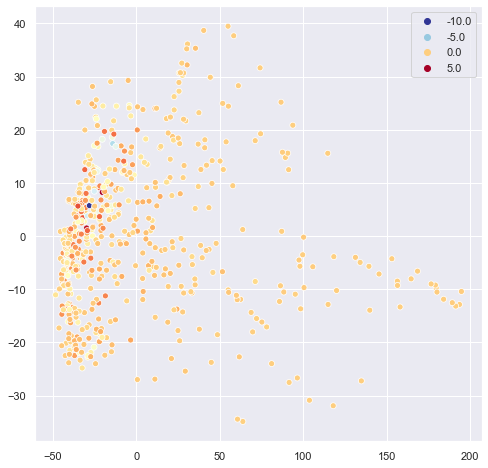

In [25]:
#colours = np.tanh(np.array(results['uns_rescale'])/10)
colours = np.array(results['uns_rescale'])
visualise_demographics(demographic_data, colours=colours)

In [26]:
def calc_local_density(demographic_data, rescale=None, **kwargs):
    dist_matrix   = calc_dist_matrix(demographic_data, rescale, **kwargs)
    local_density = np.zeros(dist_matrix.shape)
    np.divide(np.ones(dist_matrix.shape), dist_matrix, 
              where=dist_matrix!=0, out=local_density)
    return pd.Series(np.sum(local_density,1),index=constits_id)

In [27]:
local_density = calc_local_density(demographic_data, 
                                   rescale=exponent, base=10)

uns_rescale_density = results['uns_rescale'] / local_density
uns_rescale_density = preprocessing.scale(uns_rescale_density)

results['uns_rescale_density'] = uns_rescale_density
results['density'] = local_density
results.sort_values('uns_rescale_density',ascending=False).head()

,constituency,uns,uns_cut,uns_rescale,uns_rescale_density,density
ons_id,,,,,,
E14000958,Southport,4.368167,5.618753,4.940556,5.057740,11.316953
W07000078,Vale Of Glamorgan,2.818573,4.242221,4.373373,3.113603,16.189147
E14000762,Isle Of Wight,2.475303,2.298460,2.359431,3.107223,8.751725
E14000684,Eastbourne,2.104995,2.712328,2.099285,2.745669,8.796621
E14000735,Hastings and Rye,1.365259,1.966880,2.150249,2.730220,9.060383


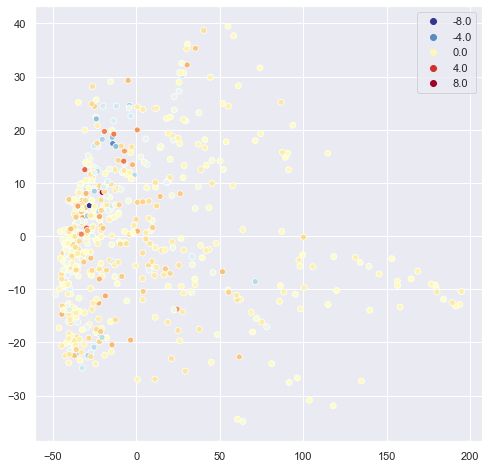

In [28]:
colours = np.array(results['uns_rescale_density'])
visualise_demographics(demographic_data, colours=colours)

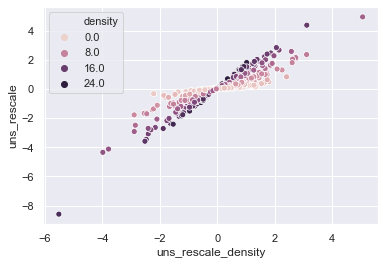

In [29]:
sns.scatterplot(y=results['uns_rescale'],x=results['uns_rescale_density'],
                hue=results['density'])

### Investigate a constituency's score

Define a constituency of interest `coi` in the cell below to see where it's score comes from.

In [30]:
def list_similar(constit, N=5):
    index = id_to_index[constit]
    dists = dist_matrix[index]
    close_indexes = np.argsort(dists)
    
    df = pd.DataFrame({'name': id_to_name[constit],
                       'distance': 0},
                      index = [constit])

    for i in range(1,N+1):
        j = close_indexes[i]
        df = df.append( pd.DataFrame({'name': constits_name[j],
                                     'distance': dists[j]},
                                     index = [constits_id[j]])
                      )
    return df

In [31]:
def list_significances(constit, significance_matrix, scores, N=5):
    index = id_to_index[constit]
    dists = dist_matrix[index]
    significances = significance_matrix[index]
    most_signif = np.argsort(-abs(significances))

    df = pd.DataFrame({'name': id_to_name[constit],
                       'distance': 0,
                       'election swing': scores.loc[constit],
                       'score contribution': 0,
                       },
                      index = [constit])
    
    for i in range(N):
        j = most_signif[i]
        df = df.append( pd.DataFrame({'name': constits_name[j],
                                      'distance': dists[j],
                                      'election swing': scores[constits_id[j]] - 0.079,
                                      'score contribution': significances[j]
                                     },
                                     index = [constits_id[j]])
                      )
    return df

In [32]:
# coi needs to a be an ONSID
coi = name_to_id['Chingford and Woodford Green']

In [33]:
significance_matrix = calc_significance_matrix(demographic_data, 
                                               scores['uns'], 
                                               rescale=exponent, 
                                               base=10)
list_significances(coi, significance_matrix, scores['uns'])

,name,distance,election swing,score contribution
E14000634,Chingford and Woodford Green,0.000000,0.019182,0.000000
E14000621,Carshalton and Wallington,0.835257,-0.139568,0.273458
E14000599,Bristol East,0.921562,-0.154791,0.266964
E14000558,Bexleyheath and Crayford,0.898574,-0.139059,0.234851
E14000861,Northampton North,1.014040,-0.138552,0.178870
E14000692,"Enfield, Southgate",0.865352,-0.111195,0.164373


In [34]:
list_similar(coi)

,name,distance
E14000634,Chingford and Woodford Green,0.000000
E14000621,Carshalton and Wallington,0.835257
E14000692,"Enfield, Southgate",0.865352
E14000558,Bexleyheath and Crayford,0.898574
E14000599,Bristol East,0.921562
E14000861,Northampton North,1.014040


In [35]:
# use these onsids to view in the separate notebook: show_constits.ipynb
list_similar(coi,5).index

Index(['E14000634', 'E14000621', 'E14000692', 'E14000558', 'E14000599',
       'E14000861'],
      dtype='object')

## Sensetivity Analysis

In [36]:
from sklearn.metrics import r2_score

def sub_sample_features(features=features,subsample_size=1):
    from itertools import combinations
    return combinations(features,subsample_size)

df = results.copy()
print('Drop feature, r2_score')
for i,exclude in enumerate(sub_sample_features(subsample_size=1)):
    df[i] = calc_campaign_conf(demographic_data.drop(columns=list(exclude)), 
                               scores['uns'], 
                               rescale=exponent, base=10)
    print(exclude,'\t', r2_score(df['uns_rescale'],df[i]))


Drop feature, r2_score
('c11PopulationDensity',) 	 0.9862760069125243
('c11HouseOwned',) 	 0.9948633104384605
('c11CarsNone',) 	 0.9947278339080398
('c11EthnicityWhite',) 	 0.9836453638657621
('c11Unemployed',) 	 0.9768436280467341
('c11Retired',) 	 0.9958891543908549
('c11FulltimeStudent',) 	 0.959806732077072
('c11Age65to74',) 	 0.9925690112541029
('c11DeprivedNone',) 	 0.9694476580708534


In [37]:
def noise(array, factor=0.1):
    mean = np.mean(array, axis=0)
    std = np.std(array, axis=0)
    rng = np.random.RandomState()
    noise = rng.normal(mean, std * factor, size=array.shape)
    return array + noise
    
print('10% noise to demographics')
df = results.copy()
for i in range(5):    
    df[i] = calc_campaign_conf(noise(demographic_data), scores['uns'], 
                               rescale=exponent, base=10)
    print(r2_score(df['uns_rescale'],df[i]))

print('\n 10% noise to score')
df = results.copy()
for i in range(5):    
    df[i] = calc_campaign_conf(demographic_data, noise(scores['uns']), 
                               rescale=exponent, base=10)
    print(r2_score(df['uns_rescale'],df[i]))

10% noise to demographics
0.9858524470200778
0.9865942755722837
0.9871984178664337
0.9829885273431885
0.9859337839531849

 10% noise to score
0.9829159587617399
0.9854196824914656
0.9816855447852747
0.9837591298598723
0.9854011690144829


In [38]:
print('base, r2_score')

for i in range(2,15):
    a = calc_campaign_conf(demographic_data, scores['uns'], rescale=exponent, base=i)
    r2 = r2_score(results['uns_rescale'], a)
    print(i,r2)

base, r2_score
2 0.8386309560798607
3 0.92919055171777
4 0.9645853520715247
5 0.9816802483589442
6 0.990767924705172
7 0.9957543823577483
8 0.9984149199448544
9 0.9996602354229658
10 1.0
11 0.9997387479172367
12 0.9990679176586389
13 0.998112797541764
14 0.9969580903194298


Given it stable to noise and parameter changes, have we actually trnasformed the data?

In [39]:
def compare(x1, x2):
    sns.scatterplot(x=x1,y=x2)
    print('r2_score = ',r2_score(preprocessing.scale(x1),
                                 preprocessing.scale(x2)))

r2_score =  0.6893014539489783


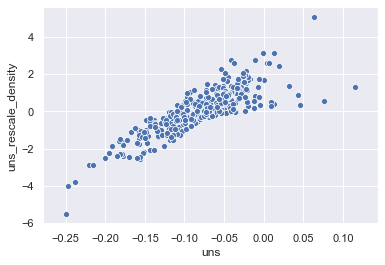

In [40]:
compare(scores['uns'],results['uns_rescale_density'])

r2_score =  0.4664244622599639


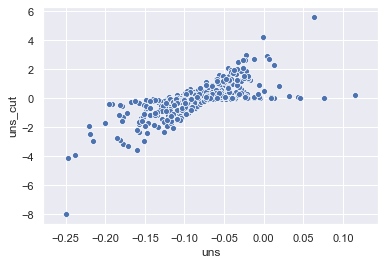

In [41]:
compare(scores['uns'],results['uns_cut'])

r2_score =  0.739472887895025


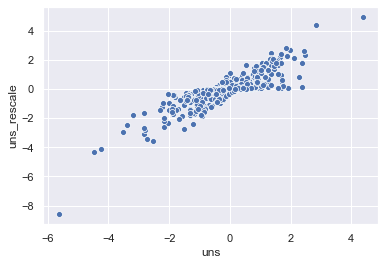

In [42]:
compare(results['uns'],results['uns_rescale'])